# Face ID with autoencoders
![](http://globbsecurity.fr/wp-content/uploads/2017/09/face-id-3d-scanning-points.jpg)

In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

# Getting the data

In [2]:
from PIL import Image
from keras.utils import to_categorical

Using TensorFlow backend.


## Retrieving the data

In [3]:
import glob
FOLDER = "C:/data/images/friends/"
files = glob.glob(FOLDER+"*.png")
len(files)

441

##### Creating the training set X

In [54]:
X_train = np.vstack([np.expand_dims(np.array(Image.open(file).resize((100,100))),axis = 0) for file in tqdm(files)])

100%|██████████████████████████████████████| 441/441 [00:00<00:00, 1057.55it/s]


##### Creating the target variable

In [55]:
matching_df = pd.DataFrame(files,columns = ["files"])
matching_df["category"] = matching_df["files"].map(lambda x : re.sub("[0-9]","",os.path.split(x)[1]).split(".")[0])
matching_df["class"] = matching_df['category'].map(lambda x : list(matching_df["category"].unique()).index(x))

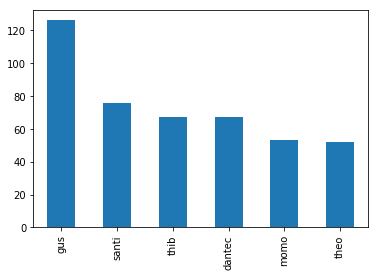

In [56]:
matching_df.category.value_counts().plot(kind = "bar")
plt.show()

In [43]:
matching_df.head()

,files,category,class
0,C:/data/images/friends\dantec1.png,dantec,0
1,C:/data/images/friends\dantec10.png,dantec,0
2,C:/data/images/friends\dantec11.png,dantec,0
3,C:/data/images/friends\dantec12.png,dantec,0
4,C:/data/images/friends\dantec13.png,dantec,0


## Preparing the data

In [57]:
X_train = np.divide(X_train,255)

In [58]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))

In [59]:
X_train.shape

(441, 30000)

# Creating the model

In [72]:
from keras.layers import Input, Dense, Lambda, Layer
from keras import optimizers
from keras.models import Model
from keras import backend as K
from keras import metrics
from scipy.stats import norm

##  Building the model

In [32]:
batch_size = 100
original_dim = 30000
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [94]:
# Encoder
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


# Sampling
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])



# Decoder
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)




# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
adam = optimizers.Adam(lr = 0.005)
vae.compile(optimizer="adam", loss=None)

C:\Users\talvesdacosta\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:50: UserWarning: Output "custom_variational_layer_12" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_12" during training.


## Training the model

In [95]:
from keras_tqdm import TQDMNotebookCallback
callback = TQDMNotebookCallback(leave_inner=True,leave_outer=True)

In [96]:
vae.fit(X_train,
        shuffle=True,
        epochs=10,
        batch_size=100,
        validation_split = 0.1,
        callbacks = [callback],verbose = 0)

## Visualizing the results

In [97]:
encoder = Model(x, z_mean)

In [98]:
X_train.shape

(441, 30000)

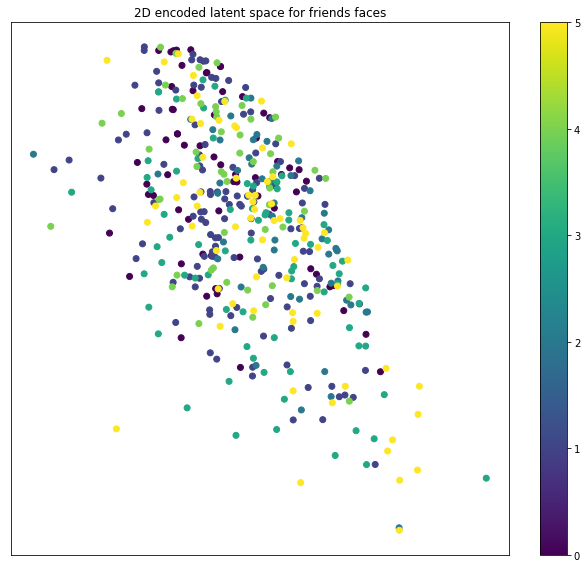

In [99]:
X_encoded = encoder.predict(X_train, batch_size=batch_size)
plt.figure(figsize=(9, 8))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=matching_df["class"])
plt.title("2D encoded latent space for friends faces")
plt.xticks(())
plt.yticks(())
plt.colorbar()
plt.tight_layout()
plt.show()

In [106]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

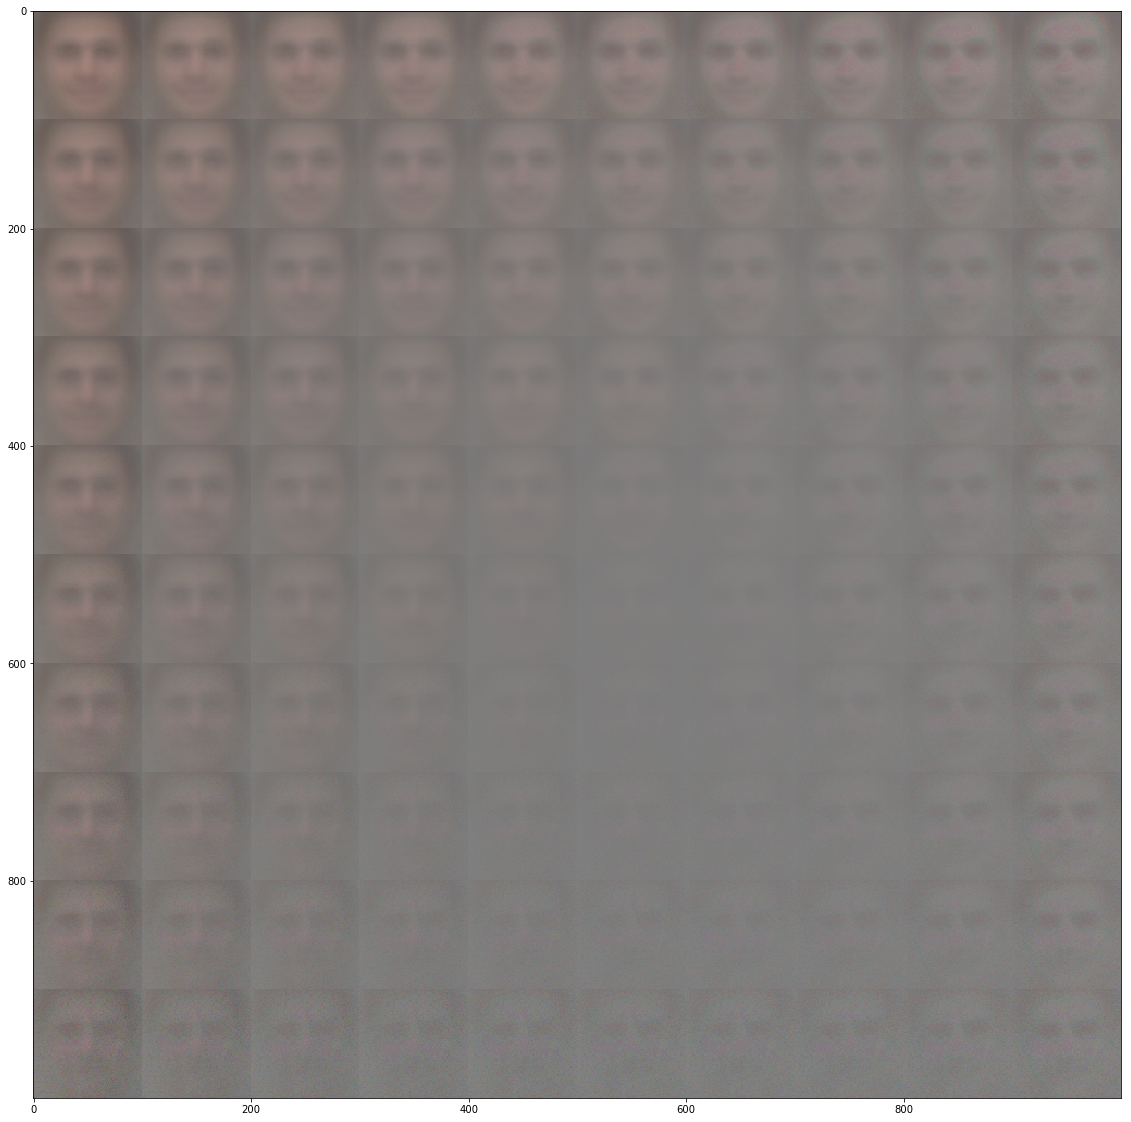

In [113]:
n = 10  
digit_size = 100
figure = np.zeros((digit_size * n, digit_size * n,3))

# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size,3)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20,20))
plt.imshow(figure) #, cmap='Greys_r')
plt.show()